<h1>Anti Money Laundering Detection System</h1>

In [1]:
!pip install pyspark

<h4>Imports Section</h4>

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_timestamp, dayofmonth, col
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import expr
from pyspark.ml.classification import RandomForestClassifier
from sklearn.model_selection import train_test_split

<h2>Data Collection</h2>

In [5]:
spark = SparkSession.builder.appName("Anti Money Laundering Detection System").config("spark.executor.memory", "6g").config("spark.driver.memory", "6g").getOrCreate()

In [6]:
data = spark.read.csv("LI-Medium_Trans.csv", header=True, inferSchema=True)

<h2>I. Data Cleaning</h2>

In [7]:
data.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|       20|800104D70|     20|800104D70|        8095.07|         US Dollar|    8095.07|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:18|     3196|800107150|   3196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:23|     1208|80010E430|   1208|80010E430|        2654.22|         US Dollar|    2654.22|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:19|     3203|80010EA80|   3203|80010EA80|       13284.41|         US Dollar|   13284.

In [8]:
data.describe().show(5)

+-------+----------------+-----------------+---------+-----------------+---------+-------------------+------------------+-------------------+-----------------+--------------+--------------------+
|summary|       Timestamp|        From Bank| Account2|          To Bank| Account4|    Amount Received|Receiving Currency|        Amount Paid| Payment Currency|Payment Format|       Is Laundering|
+-------+----------------+-----------------+---------+-----------------+---------+-------------------+------------------+-------------------+-----------------+--------------+--------------------+
|  count|        31251483|         31251483| 31251483|         31251483| 31251483|           31251483|          31251483|           31251483|         31251483|      31251483|            31251483|
|   mean|            NULL| 275257.405870851| Infinity|391286.1635868928| Infinity|  7953412.507903153|              NULL|  5392240.185796354|             NULL|          NULL|5.132876414216887E-4|
| stddev|           

In [9]:
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|        0|        0|       0|      0|       0|              0|                 0|          0|               0|             0|            0|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+



In [10]:
data = data.withColumnRenamed("Account", "From").withColumnRenamed("Account.1", "To")
data.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|       20|800104D70|     20|800104D70|        8095.07|         US Dollar|    8095.07|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:18|     3196|800107150|   3196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:23|     1208|80010E430|   1208|80010E430|        2654.22|         US Dollar|    2654.22|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:19|     3203|80010EA80|   3203|80010EA80|       13284.41|         US Dollar|   13284.

<h2>II. Exploratory Data Analysis (EDA) </h2>

In [69]:
Laundering = data[data['Is Laundering']==1]
Non_Laundering = data[data['Is Laundering']==0]

In [70]:
laundering_count = data.filter(data["Is Laundering"] == 1).count()
non_laundering_count = data.filter(data["Is Laundering"] == 0).count()

print("Number of Laundering cases:", laundering_count)
print("Number of Non-Laundering cases:", non_laundering_count)

Number of Laundering cases: 16041
Number of Non-Laundering cases: 31235442


In [71]:
diff_currency_trans = data.filter(data['Receiving Currency'] != data['Payment Currency'])
inter_currency_counts = diff_currency_trans.groupBy('Receiving Currency', 'Payment Currency').count()
inter_currency_counts.describe().show()

+-------+------------------+-----------------+-----------------+
|summary|Receiving Currency| Payment Currency|            count|
+-------+------------------+-----------------+-----------------+
|  count|               208|              208|              208|
|   mean|              NULL|             NULL|2249.418269230769|
| stddev|              NULL|             NULL|9956.806586647941|
|    min| Australian Dollar|Australian Dollar|                1|
|    max|              Yuan|             Yuan|           101036|
+-------+------------------+-----------------+-----------------+



In [72]:
same_currency_trans = data.filter(data['Receiving Currency'] == data['Payment Currency'])
same_currency_counts = same_currency_trans.groupBy('Payment Currency').count()
same_currency_counts.describe().show()

+-------+-----------------+------------------+
|summary| Payment Currency|             count|
+-------+-----------------+------------------+
|  count|               15|                15|
|   mean|             NULL|2052240.2666666666|
| stddev|             NULL| 3114979.467933926|
|    min|Australian Dollar|            631457|
|    max|             Yuan|          11592839|
+-------+-----------------+------------------+



In [73]:
same_curr = data.filter(col('Receiving Currency') == col('Payment Currency'))
cross_currL = data.filter(col('Receiving Currency') != col('Payment Currency'))

same_curr_count = same_curr.count()
cross_curr_count = cross_currL.count()

print("Number of transactions with the same currency:", same_curr_count)
print("Number of transactions with different currencies:", cross_curr_count)

Number of transactions with the same currency: 30783604
Number of transactions with different currencies: 467879


<h4>Cross-Currency Transactions vs Same Currency Transactions</h4>

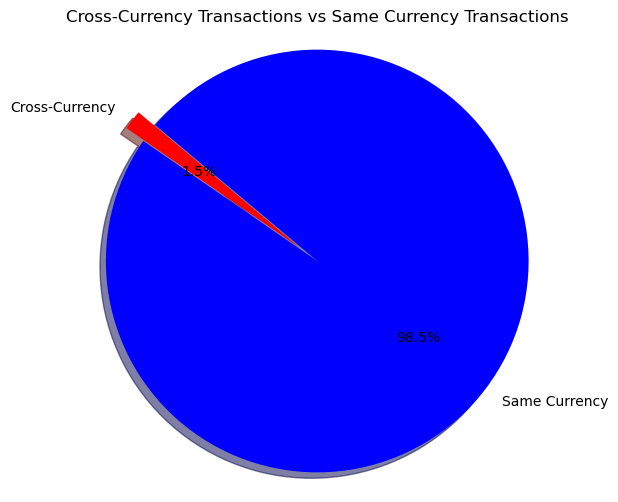

In [74]:
labels = ['Cross-Currency', 'Same Currency']
sizes = [cross_curr_count, same_curr_count] 
colors = ['red', 'blue']
explode = (0.1, 0) 

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Same Currency Transactions')
plt.axis('equal')
plt.show()

<h4>Distribution of Amount Paid and Amount Received</h4>

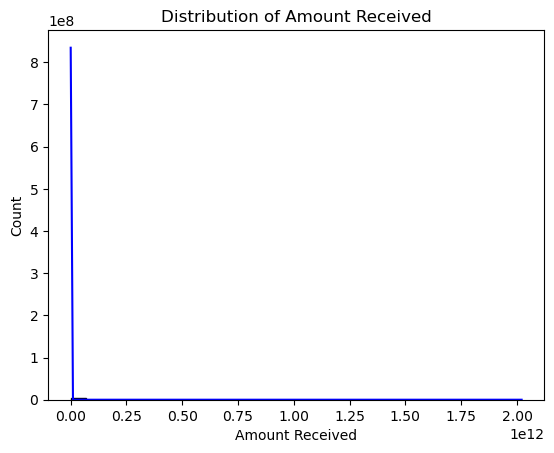

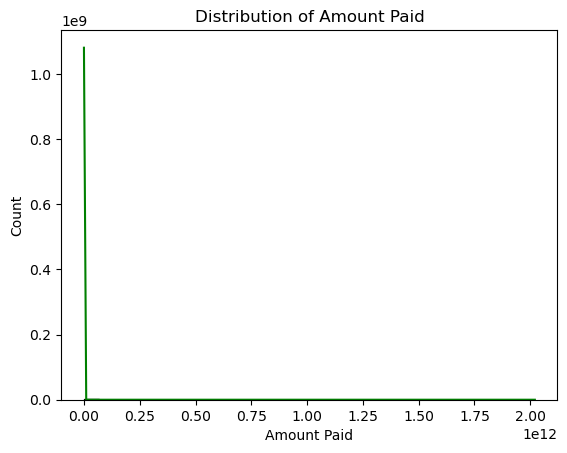

In [75]:
sample_df = data.select("Amount Received", "Amount Paid").sample(fraction=0.1).toPandas()

sns.histplot(sample_df, x="Amount Received", bins=30, color='blue', kde=True)
plt.title('Distribution of Amount Received')
plt.show()

sns.histplot(sample_df, x="Amount Paid", bins=30, color='green', kde=True)
plt.title('Distribution of Amount Paid')
plt.show()

<h4>Payment Formats Analysis</h4>

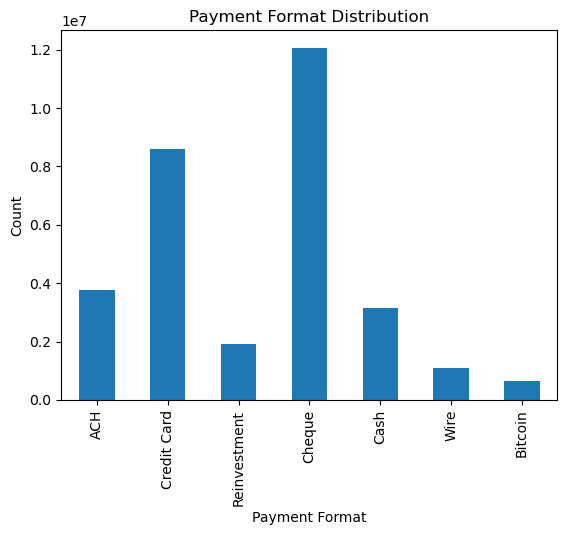

In [76]:
category_counts = data.groupBy("Payment Format").count()

category_counts_pd = category_counts.toPandas()
category_counts_pd.plot(kind='bar', x='Payment Format', y='count', legend=None)
plt.title('Payment Format Distribution')
plt.ylabel('Count')
plt.show()

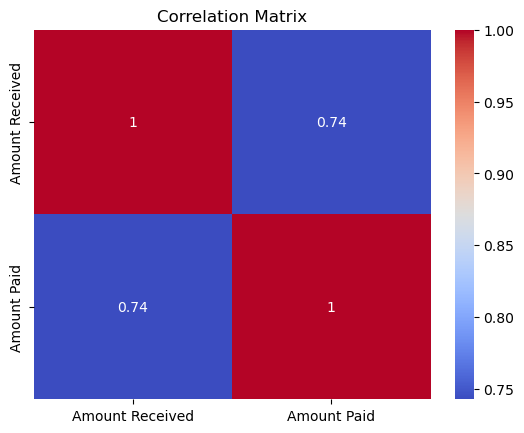

In [77]:
numeric_features = ["Amount Received", "Amount Paid"]
numeric_data = data.select(numeric_features).sample(fraction=0.1).toPandas()

corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

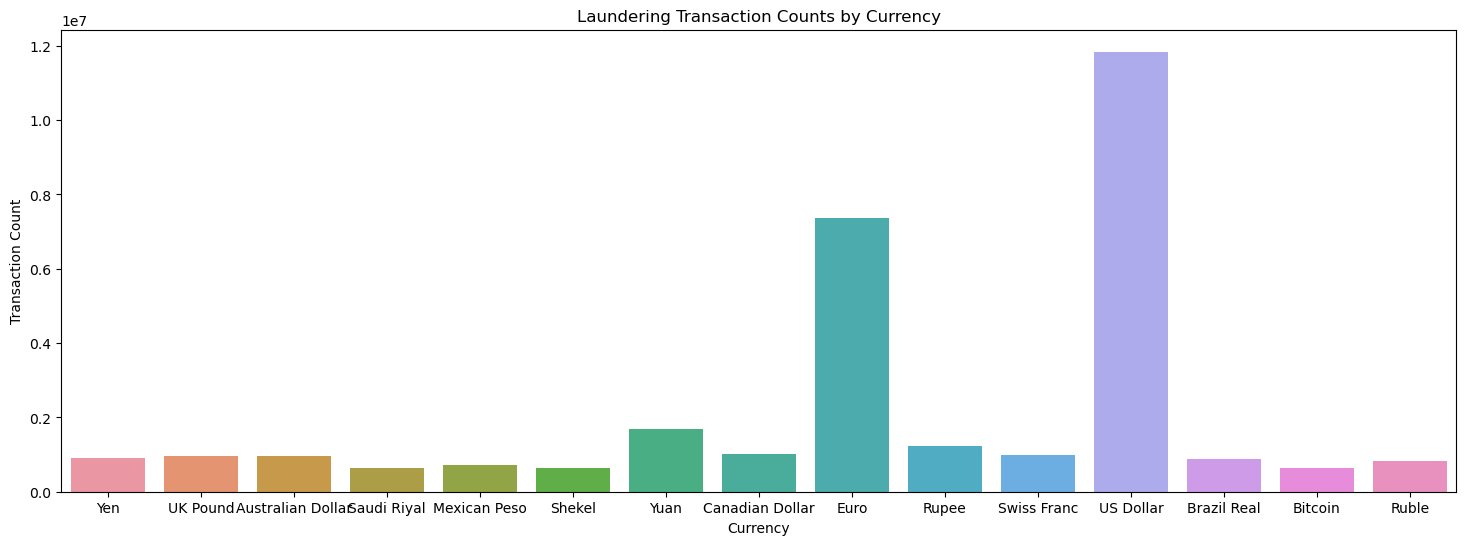

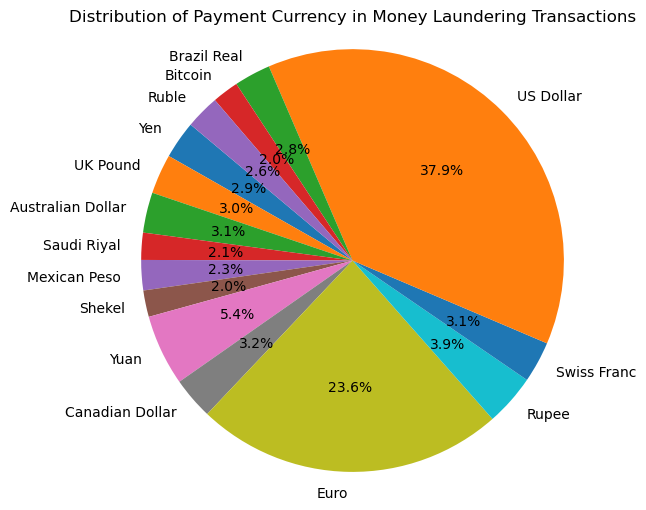

In [78]:
transaction_counts = data.groupBy('Payment Currency').agg(F.count('*').alias('Transaction Count'))
transaction_counts_pd = transaction_counts.toPandas()

plt.figure(figsize=(18, 6))
sns.barplot(x='Payment Currency', y='Transaction Count', data=transaction_counts_pd)
plt.title('Laundering Transaction Counts by Currency')
plt.xlabel('Currency')
plt.ylabel('Transaction Count')
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(transaction_counts_pd['Transaction Count'], labels=transaction_counts_pd['Payment Currency'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Payment Currency in Money Laundering Transactions')
plt.axis('equal')  
plt.show()

In [79]:
payment_format_counts = Laundering.groupBy("Payment Format").count().withColumnRenamed("count", "Transaction Count")
payment_format_counts.show(5)

+--------------+-----------------+
|Payment Format|Transaction Count|
+--------------+-----------------+
|           ACH|            11679|
|   Credit Card|             1309|
|        Cheque|             2199|
|          Cash|              637|
|       Bitcoin|              217|
+--------------+-----------------+



<h4>Payment Formats in Laundering Transactions</h4>

In [80]:
payment_format_counts = Laundering.groupBy("Payment Format").count().withColumnRenamed("count", "Transaction Count")
payment_format_pd = payment_format_counts.toPandas()

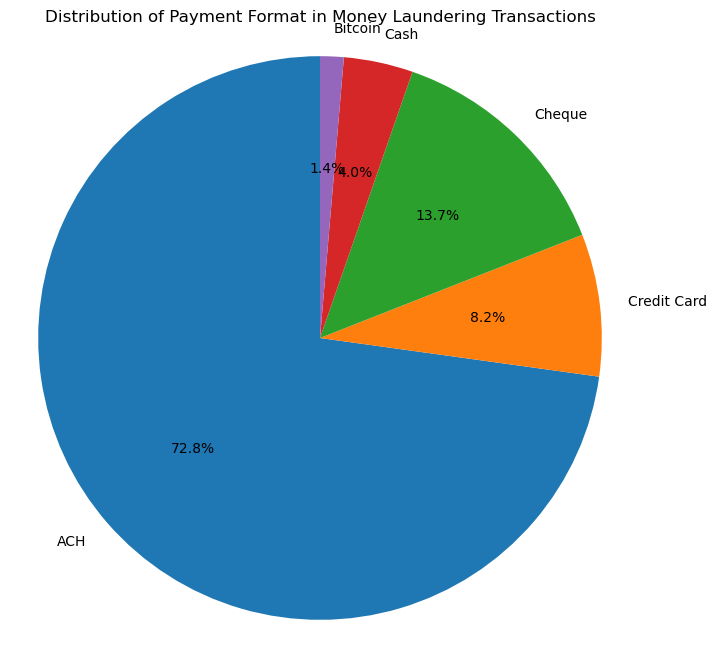

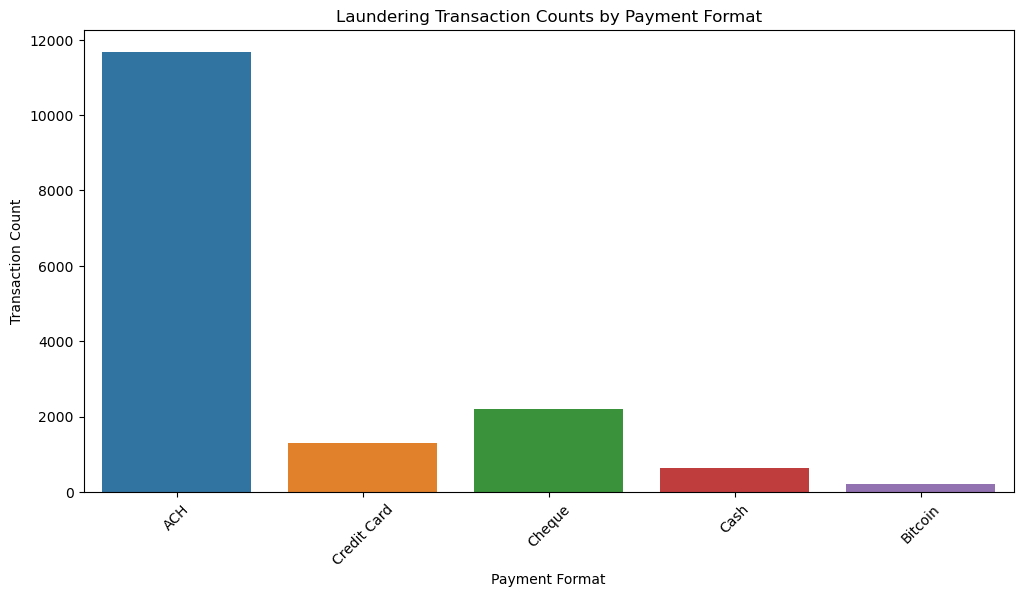

In [81]:
plt.figure(figsize=(8, 8))  
plt.pie(payment_format_pd['Transaction Count'], labels=payment_format_pd['Payment Format'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Payment Format in Money Laundering Transactions')
plt.axis('equal')  
plt.show()

plt.figure(figsize=(12, 6))  
sns.barplot(x='Payment Format', y='Transaction Count', data=payment_format_pd)
plt.title('Laundering Transaction Counts by Payment Format')
plt.xlabel('Payment Format')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45) 
plt.show()

<h4>Laundering Transactions over a period of time</h4>

In [82]:
Laundering = Laundering.withColumn("Timestamp", to_timestamp("Timestamp", 'yyyy/MM/dd HH:mm'))
Laundering = Laundering.withColumn("Day", dayofmonth("Timestamp"))

In [83]:
daily_transactions = Laundering.groupBy("Day").count().orderBy("Day")
daily_transactions_pd = daily_transactions.toPandas()

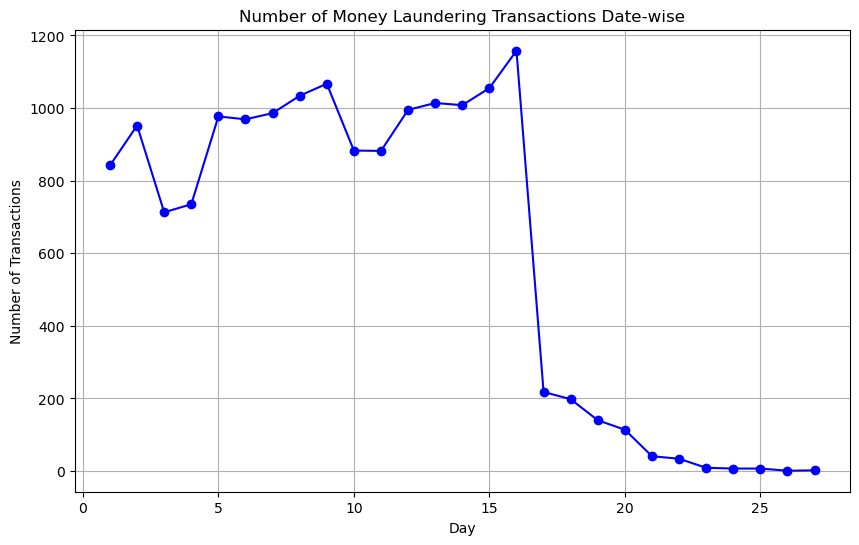

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(daily_transactions_pd['Day'], daily_transactions_pd['count'], marker='o', color='b')
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

<h2>III. Feature Engineering</h2>

In [85]:
categoricalColumns = ['Receiving Currency', 'Payment Currency', 'Payment Format']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

numericCols = ['Amount Received', 'Amount Paid']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
stages += [scaler]

In [86]:
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index").fit(data)
    for column in ["Receiving Currency", "Payment Currency", "Payment Format"]
]

encoder = OneHotEncoder(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=[indexer.getOutputCol().replace("_index", "_vec") for indexer in indexers]
)

assembler = VectorAssembler(
    inputCols=[indexer.getOutputCol().replace("_index", "_vec") for indexer in indexers] + ["Amount Received", "Amount Paid"],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + [encoder, assembler])
transformed_df = pipeline.fit(data).transform(data)

transformed_df.show(5) 

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+------------------------+----------------------+--------------------+----------------------+--------------------+------------------+--------------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Receiving Currency_index|Payment Currency_index|Payment Format_index|Receiving Currency_vec|Payment Currency_vec|Payment Format_vec|            features|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+------------------------+----------------------+--------------------+----------------------+--------------------+------------------+--------------------+
|2022/09/01 00:15|       20|800104D70|     20|800104D70|        8095.07|         US Dollar|

<h2>IV. Model Building for Laundering Detection</h2>

<h3>1. Logistic Regression</h3>

In [87]:
train_data, test_data = transformed_df.randomSplit([0.3, 0.7], seed=42)

In [88]:
lr = LogisticRegression(featuresCol='features', labelCol='Is Laundering', maxIter=10)

lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

<h4>Evaluation of Logistic Regression</h4>

In [89]:
evaluator = BinaryClassificationEvaluator(labelCol="Is Laundering", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Test Area Under ROC: ", auc)

Test Area Under ROC:  0.8228318390026694


In [91]:
accuracy_df = predictions.withColumn('correct', expr("cast(prediction = `Is Laundering` as int)"))
accuracy = accuracy_df.agg({"correct": "avg"}).collect()[0]['avg(correct)']

print("Accuracy of the model: ", accuracy)

Accuracy of the model:  0.9994866301417735


<h3>2. Random Forest Classifier</h3>

In [26]:
rf = RandomForestClassifier(labelCol="Is Laundering", featuresCol="scaledFeatures")
stages += [rf]
pipeline = Pipeline(stages=stages)
(train, test) = data.randomSplit([0.5, 0.5], seed=42)
model = pipeline.fit(train)

<h4>Evaluation of Random Forest Classifer</h4>

In [27]:
predictions = model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol="Is Laundering")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area under ROC = {accuracy}")

Area under ROC = 0.5
